In [2]:
library(ggplot2)
library(dplyr)
library(readr)
library(tidyr)

### Outliers

In [ ]:
setwd("D:/THUCHANH/Diabetes_Prediction/data")

In [3]:
df <- read_csv('data/diabetes_012_health_indicators_BRFSS2015.csv')
head(df)

Rows: 253680 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,⋯,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,1,1,40,1,0,0,0,0,⋯,1,0,5,18,15,1,0,9,4,3
0,0,0,0,25,1,0,0,1,0,⋯,0,1,3,0,0,0,0,7,6,1
0,1,1,1,28,0,0,0,0,1,⋯,1,1,5,30,30,1,0,9,4,8
0,1,0,1,27,0,0,0,1,1,⋯,1,0,2,0,0,0,0,11,3,6
0,1,1,1,24,0,0,0,1,1,⋯,1,0,2,3,0,0,0,11,5,4
0,1,1,1,25,1,0,0,1,1,⋯,1,0,2,0,2,0,1,10,6,8


gom nhóm nhãn hiếm cho Education.       
1: Less than high school.       
2: High School.     
3: College.     
4: College gradute. 

In [4]:
df <- df %>%
  mutate(Education = case_when(
    Education %in% c(1,2,3) ~ 1,
    Education %in% c(4,5,6) ~ Education
  )) %>%
  mutate(Education = factor(Education, levels = c(1,4,5,6), labels = c(1,2,3,4)))

df$Education <- as.double(as.character(df$Education))

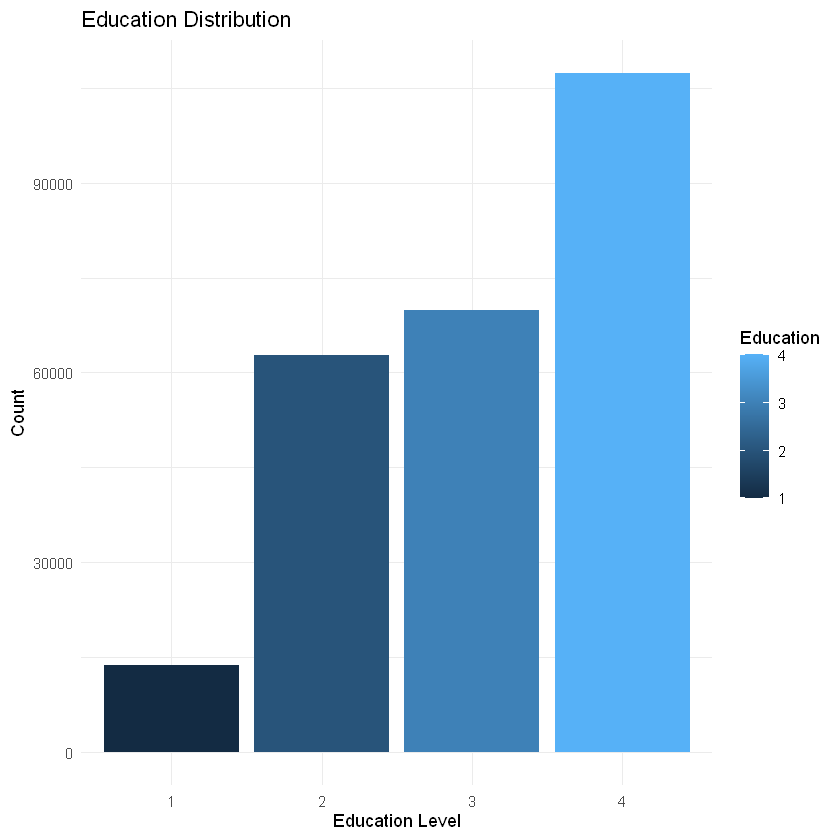

In [9]:
ggplot(df, aes(x=as.factor(Education), fill=Education)) +
    geom_bar() +
    labs(title = "Education Distribution",
         x = "Education Level",
         y = "Count") +
    theme_minimal() 

In [10]:
robust_scaler <- function(x) {
  Q1 <- quantile(x, 0.25) 
  Q3 <- quantile(x, 0.75) 
  IQR <- Q3 - Q1          
  median_x <- median(x)   

  scaled_x <- (x - median_x) / IQR
  return(scaled_x)
}

df <- df %>%
  mutate(BMI = robust_scaler(BMI)) %>%
  mutate(PhysHlth = robust_scaler(PhysHlth)) %>%
  mutate(MentHlth = robust_scaler(MentHlth))

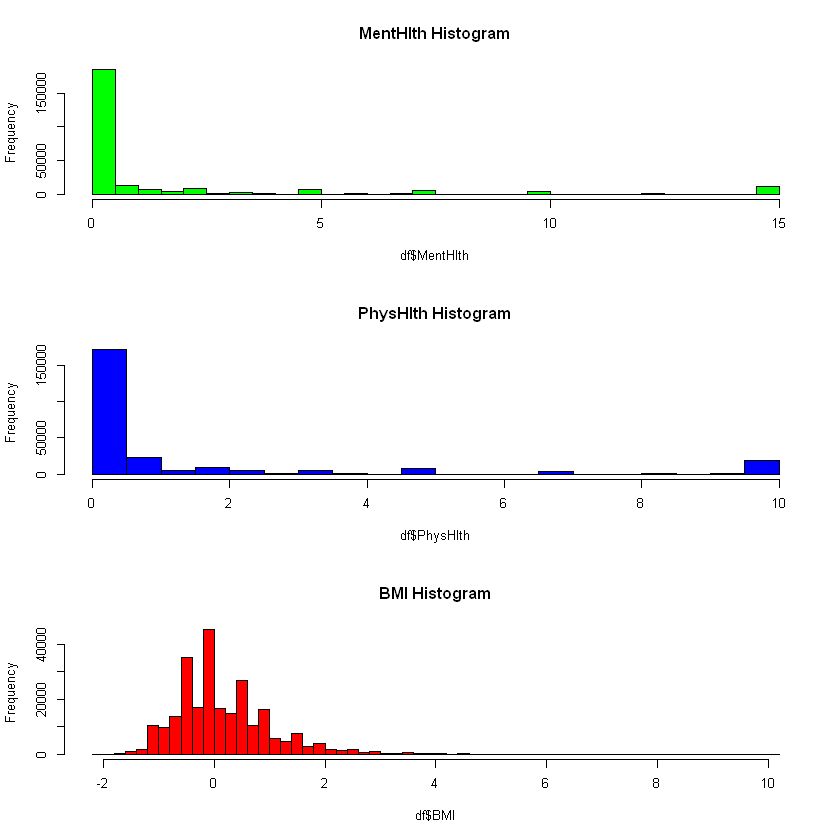

In [11]:
# plot the distribution of BMI, PhysHlth, and MentHlth
par(mfrow=c(3,1), bg='white')
hist(df$MentHlth, breaks=31, col='green', main='MentHlth Histogram')
hist(df$PhysHlth, breaks=31, col='blue', main='PhysHlth Histogram')
hist(df$BMI, breaks=84, col='red', main='BMI Histogram')

In [ ]:
write.csv(df, 'data/clean_outliers.csv', row.names=FALSE)

### Imbalanced 

In [12]:
df <- read.csv('clean_outliers.csv')

Under Sampling 

In [19]:
under_sampling_3c <- function(data, name_class) {
    class_fact <- as.factor(data[, name_class])
    data_split <- split(data, class_fact)
    n_class <- sapply(data_split, FUN = nrow)
    n_minor <- min(n_class)
    
    new_data <- do.call(rbind, lapply(data_split, function(class_data) {
        id_sample <- sample(1:nrow(class_data), size = n_minor, replace = FALSE)
        class_data[id_sample, ]
    }))
    
    return(new_data)
}


In [14]:
glimpse(df)

Rows: 253,680
Columns: 22
$ Diabetes_012         <int> 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0…
$ HighBP               <int> 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1…
$ HighChol             <int> 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1…
$ CholCheck            <int> 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ BMI                  <dbl> 1.8571429, -0.2857143, 0.1428571, 0.0000000, -0.4…
$ Smoker               <int> 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0…
$ Stroke               <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0…
$ HeartDiseaseorAttack <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0…
$ PhysActivity         <int> 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1…
$ Fruits               <int> 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1…
$ Veggies              <int> 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1…
$ HvyAlcoholConsump    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ AnyHealthcar

In [ ]:
with(df, table(Diabetes_012))

Diabetes_012
     0      1      2 
213703   4631  35346 

In [20]:
set.seed(123)
df_under <- under_sampling_3c(df, "Diabetes_012")
with(df_under, table(Diabetes_012))

Diabetes_012
   0    1    2 
4631 4631 4631 

In [21]:
# save the under-sampled data to csv 
write.csv(df_under, 'under_sampled.csv', row.names=FALSE)

Over Sampling

In [22]:
over_sampling_3c <- function(data, name_class) {
    class_fact <- as.factor(data[, name_class])
    data_split <- split(data, class_fact)
    n_class <- sapply(data_split, FUN = nrow)
    n_major <- max(n_class)
    
    new_data <- do.call(rbind, lapply(data_split, function(class_data) {
        id_sample <- sample(1:nrow(class_data), size = n_major, replace = TRUE)
        class_data[id_sample, ]
    }))
    
    return(new_data)
}

In [23]:
df_over <- over_sampling_3c(df, "Diabetes_012")
with(df_over, table(Diabetes_012))

Diabetes_012
     0      1      2 
213703 213703 213703 

In [24]:
write.csv(df_over, 'over_sampled.csv', row.names=FALSE)

SMOTE

In [26]:
library(themis)

In [34]:
df$Diabetes_012 <- as.factor(df$Diabetes_012)
set.seed(123)
df_smote <- smotenc(df= df, var = "Diabetes_012", k = 5, over_ratio = 1)

In [35]:
with(df_smote, table(Diabetes_012))

Diabetes_012
     0      1      2 
213703 213703 213703 

In [36]:
write.csv(df_smote, 'smote.csv', row.names=FALSE)